In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv
/kaggle/input/qa-intents-dataset-university-domain/labels_description.txt
/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset 
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
train_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [6]:
full_data = pd.concat([train_data, test_data])
full_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_data, test_size=0.2, random_state=42)
unique_values_normalized = train['intent'].value_counts(normalize=True)
print(unique_values_normalized*100)

intent
sched_teacher                8.582817
sched_for_group              3.126661
sched_for_group_day          3.046944
wifi                         2.143490
status_free                  2.037201
                               ...   
location_general             0.168291
loc_nsu_cafeteria            0.168291
student_trade_union_enter    0.159433
loc_passport_office          0.159433
staff_trade_union_enter      0.159433
Name: proportion, Length: 142, dtype: float64


In [8]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавление дополнительного измерения
#         print(f'x shape: {x.shape}')
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [10]:
# !
from sklearn.preprocessing import LabelEncoder

# Создание LabelEncoder
le = LabelEncoder()

# Подготовка данных
full_data = pd.concat([train_data, test_data])
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

# # Токенизация и преобразование в TF-IDF
# tokenizer = word_tokenize
# vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')

# train_texts = vectorizer.fit_transform(train['text']).toarray()
# test_texts = vectorizer.transform(test['text']).toarray()

# # Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
# train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
# test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)


In [11]:
# Токенизация и преобразование в TF-IDF
tokenizer = word_tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer)

train_texts = vectorizer.fit_transform(train['text']).toarray()
test_texts = vectorizer.transform(test['text']).toarray()

# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
# Подготовка данных
# full_data = pd.concat([train_data, test_data])
# train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# le = LabelEncoder()
# train_labels = le.fit_transform(train['intent'])
# test_labels = le.transform(test['intent'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


100%|██████████| 89/89 [00:00<00:00, 158.54it/s]


Epoch 1, Train Loss: 3.7563275862010275, Val Loss: 1.956818285283078


100%|██████████| 89/89 [00:00<00:00, 167.13it/s]


Epoch 2, Train Loss: 0.9587337061467319, Val Loss: 0.42236413379733484


100%|██████████| 89/89 [00:00<00:00, 169.93it/s]


Epoch 3, Train Loss: 0.2619736577481791, Val Loss: 0.19545055557502788


100%|██████████| 89/89 [00:00<00:00, 166.29it/s]


Epoch 4, Train Loss: 0.1484804228739681, Val Loss: 0.14917291872454494


100%|██████████| 89/89 [00:00<00:00, 171.92it/s]


Epoch 5, Train Loss: 0.1163130800738382, Val Loss: 0.13354792907373625


100%|██████████| 89/89 [00:00<00:00, 172.53it/s]


Epoch 6, Train Loss: 0.10360585642508931, Val Loss: 0.12724658565365532


100%|██████████| 89/89 [00:00<00:00, 165.93it/s]


Epoch 7, Train Loss: 0.09675506321204135, Val Loss: 0.12212895068831825


100%|██████████| 89/89 [00:00<00:00, 166.18it/s]


Epoch 8, Train Loss: 0.09319201209608771, Val Loss: 0.12344516919182844


100%|██████████| 89/89 [00:00<00:00, 166.17it/s]


Epoch 9, Train Loss: 0.09060629654778617, Val Loss: 0.12264105334375681


100%|██████████| 89/89 [00:00<00:00, 165.20it/s]


Epoch 10, Train Loss: 0.08915494464070038, Val Loss: 0.12119996527947612


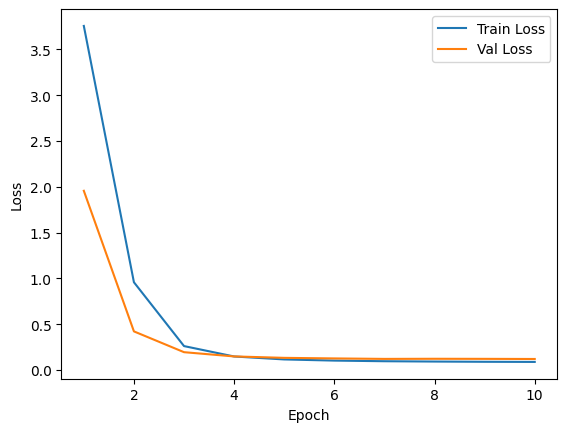

In [13]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_texts.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 10

for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for i, (texts, labels) in enumerate(tqdm(train_loader)):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(tqdm(test_loader)):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# Прогнозирование на тестовом наборе
predictions = []
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average = 'weighted'))

0.9529522393315497
(0.9489597854486564, 0.9518243003896564, 0.9485998945974757, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


M-USE

In [15]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

In [16]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:
# Создание пользовательского Dataset класса
class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


In [18]:
# Определение модели LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x.unsqueeze(1))
        out = self.fc(hn[-1])
        return out

In [19]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
model = AutoModel.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Load your dataset
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv', delimiter='\t', encoding="utf-8", names=['text', 'intent'])
full_data = pd.concat([train_data, test_data])

# Split the data into train and test sets
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Extract embeddings
with torch.no_grad():
    train_embeddings = model(**train_encodings).pooler_output
    test_embeddings = model(**test_encodings).pooler_output

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

100%|██████████| 89/89 [00:00<00:00, 643.56it/s]


Epoch 1, Train Loss: 3.2163938337952827, Val Loss: 1.7316469931870364


100%|██████████| 89/89 [00:00<00:00, 651.58it/s]


Epoch 2, Train Loss: 1.1862156296586854, Val Loss: 0.8882883050468531


100%|██████████| 89/89 [00:00<00:00, 635.84it/s]


Epoch 3, Train Loss: 0.684196964539482, Val Loss: 0.5968973904513242


100%|██████████| 89/89 [00:00<00:00, 623.50it/s]


Epoch 4, Train Loss: 0.4876316531690592, Val Loss: 0.45415242451630283


100%|██████████| 89/89 [00:00<00:00, 673.85it/s]


Epoch 5, Train Loss: 0.3806279911409019, Val Loss: 0.3718566959828473


100%|██████████| 89/89 [00:00<00:00, 651.60it/s]


Epoch 6, Train Loss: 0.3149754451244816, Val Loss: 0.31075663161411715


100%|██████████| 89/89 [00:00<00:00, 666.97it/s]


Epoch 7, Train Loss: 0.26779909942710706, Val Loss: 0.2807371696729339


100%|██████████| 89/89 [00:00<00:00, 621.92it/s]


Epoch 8, Train Loss: 0.23563740656792947, Val Loss: 0.25295367786723577


100%|██████████| 89/89 [00:00<00:00, 668.41it/s]


Epoch 9, Train Loss: 0.20984315392020403, Val Loss: 0.223915751270029


100%|██████████| 89/89 [00:00<00:00, 656.03it/s]


Epoch 10, Train Loss: 0.19028635183217335, Val Loss: 0.21105141933546978


100%|██████████| 89/89 [00:00<00:00, 476.10it/s]


Epoch 11, Train Loss: 0.17511186364077813, Val Loss: 0.20755487035834388


100%|██████████| 89/89 [00:00<00:00, 666.80it/s]


Epoch 12, Train Loss: 0.16281912292725811, Val Loss: 0.18954541735099942


100%|██████████| 89/89 [00:00<00:00, 643.79it/s]


Epoch 13, Train Loss: 0.15390724255558283, Val Loss: 0.18154706812223023


100%|██████████| 89/89 [00:00<00:00, 665.06it/s]


Epoch 14, Train Loss: 0.14445821303483786, Val Loss: 0.18204148128377587


100%|██████████| 89/89 [00:00<00:00, 653.41it/s]


Epoch 15, Train Loss: 0.13819352926016276, Val Loss: 0.1704110319443633


100%|██████████| 89/89 [00:00<00:00, 639.67it/s]


Epoch 16, Train Loss: 0.1322461984888057, Val Loss: 0.1651703582218524


100%|██████████| 89/89 [00:00<00:00, 640.63it/s]


Epoch 17, Train Loss: 0.12796823284390882, Val Loss: 0.16189237849347377


100%|██████████| 89/89 [00:00<00:00, 640.95it/s]


Epoch 18, Train Loss: 0.1234237237308417, Val Loss: 0.1608620775821671


100%|██████████| 89/89 [00:00<00:00, 642.97it/s]


Epoch 19, Train Loss: 0.1199033843741222, Val Loss: 0.15988772200273998


100%|██████████| 89/89 [00:00<00:00, 641.40it/s]


Epoch 20, Train Loss: 0.1156517052271063, Val Loss: 0.15915040902039979


100%|██████████| 89/89 [00:00<00:00, 649.65it/s]


Epoch 21, Train Loss: 0.11282850935575012, Val Loss: 0.15646574696463145


100%|██████████| 89/89 [00:00<00:00, 659.37it/s]


Epoch 22, Train Loss: 0.11117921598788573, Val Loss: 0.16193506919014988


100%|██████████| 89/89 [00:00<00:00, 662.13it/s]


Epoch 23, Train Loss: 0.10850604194633283, Val Loss: 0.15032685031653958


100%|██████████| 89/89 [00:00<00:00, 672.28it/s]


Epoch 24, Train Loss: 0.10569014765913189, Val Loss: 0.14783417464369972


100%|██████████| 89/89 [00:00<00:00, 669.82it/s]


Epoch 25, Train Loss: 0.1041881848887142, Val Loss: 0.14896113268005545


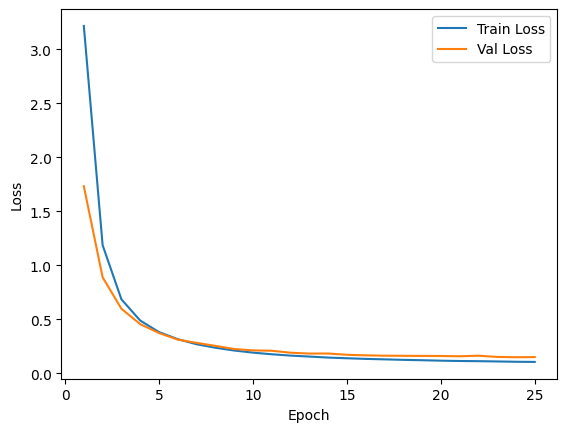

In [20]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25

for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
# Прогнозирование на тестовом наборе
predictions = []
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

In [22]:
print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

precision_recall_fscore weighted (0.9397969107196289, 0.9422600070846617, 0.9380412074206409, None)
balanced_accuracy 0.9410647605878505


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
